# Validation of a Multi-Device Leap Motion Setup

This script will prepare multi-device Leap Motion data for comparison with a gold-standard motion capture setup.

The following steps will be performed:
    1) Sensor data will be read into the script.
    2) Sensor data will be cleaned using gap-filling and low-pass filtering.
    3) Sensor data will be orientated to a reference sensor using a Kabsch algorithm.
    4) Data fusion between sensor output will be performed, resulting in only one co-ordinate for each joint.
    5) Data will be stored in a text file, ready for quantification of kinematic outputs in Vicon Bodybuilder.

# Import Data

In [367]:
from __future__ import print_function
import pandas as pd
import numpy as np
import rmsd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import savgol_filter
from scipy import signal
import scipy.interpolate as spi
from ezc3d import c3d

In [368]:
sensor_3 = pd.read_csv('Data/sensor1.csv')
sensor_2 = pd.read_csv('Data/sensor2.csv')
sensor_1 = pd.read_csv('Data/sensor3.csv')

# Gap Filling and Smoothing

In [369]:
def spline_resample(signal, current_timeseries, target_timeseries):
    s = spi.splrep(current_timeseries, signal)
    return spi.splev(target_timeseries, s)

def correct_variable_hz(df, column_names):
    time = np.array(df.iloc[:,0])
    current_timeseries = np.array(time - time[0]) #remove offset
    n = len(time) #number of frames
    avg_hz = n/current_timeseries[len(current_timeseries)-1] #average fps
    target_timeseries = np.r_[0:n] / avg_hz #evenly distributed timeseries

    df.iloc[:,0] = target_timeseries
    for i in range(1,df.shape[1]):
        s = np.array(df.iloc[:,i])
        test = spline_resample(s,current_timeseries,target_timeseries)
        df.iloc[:,i] = test

    us_df = pd.DataFrame(columns = column_names)

    for i in range(0,df.shape[1]): 
        us_df.iloc[:,i] = signal.resample(df.iloc[:,i],len(sensor_1))

    return us_df

In [370]:
#remove duplicate frames
signal_1 = sensor_1.drop_duplicates(subset=sensor_1.columns.difference(['time']))
signal_2 = sensor_2.drop_duplicates(subset=sensor_2.columns.difference(['time']))
signal_3 = sensor_3.drop_duplicates(subset=sensor_3.columns.difference(['time']))
column_names = sensor_1.columns

In [371]:
signal_1 = correct_variable_hz(signal_1, column_names)
signal_2 = correct_variable_hz(signal_2, column_names)
signal_3 = correct_variable_hz(signal_3, column_names)

In [372]:
#smooth data using a savistky-golay filter
for i in range(1,signal_1.shape[1]):
    signal_1.iloc[:,i] = savgol_filter(signal_1.iloc[:,i], 17, 2, mode='interp', axis=0)
    signal_2.iloc[:,i] = savgol_filter(signal_2.iloc[:,i], 17, 2, mode='interp', axis=0)
    signal_3.iloc[:,i] = savgol_filter(signal_3.iloc[:,i], 17, 2, mode='interp', axis=0)

# Register all data into the same co-ordinate frame

In [7]:
def plot(A, B, C):
    ax = plt.axes(projection='3d')  
    ax.scatter(A[:,0], A[:,1], A[:,2], marker='o',color='red')
    ax.scatter(B[:,0], B[:,1], B[:,2], marker='o',color='blue')
    ax.scatter(C[:,0], C[:,1], C[:,2], marker='o',color='gray')
    print("S1-S2 RMSD", rmsd.rmsd(A, B))
    print("S1-S3 RMSD", rmsd.rmsd(A, C))
    print("S2-S3 RMSD", rmsd.rmsd(B, C))

In [8]:
def kabsch_signal(signal1,signal2,signal3):
    for a in range(0,len(signal1)): #for number of frames
        
        #format frame for kabsch algorithm
        signal1_output = np.zeros((21,3))
        for i in range(0,21): #for number of markers
            signal1_output[i, :] = np.array(signal1.iloc[a, i*3+1:i*3+4])
        signal2_output = np.zeros((21,3))
        for i in range(0,21): #for number of markers
            signal2_output[i, :] = np.array(signal2.iloc[a, i*3+1:i*3+4])    
        signal3_output = np.zeros((21,3))
        for i in range(0,21): #for number of markers
            signal3_output[i, :] = np.array(signal3.iloc[a, i*3+1:i*3+4])
            
        #centre each sensor's data
        signal1_output -= rmsd.centroid(signal1_output)
        signal2_output -= rmsd.centroid(signal2_output)
        signal3_output -= rmsd.centroid(signal3_output)

        #calculte the appropriate rotation of each signal towards the reference sensor
        U_1 = rmsd.kabsch(signal2_output, signal1_output)
        U_2 = rmsd.kabsch(signal3_output, signal1_output)

        #apply rotation to signal
        signal2_output = np.dot(signal2_output, U_1)
        signal3_output = np.dot(signal3_output, U_2)
        
        #format frame to be stored again
        for i in range(0,21): #for number of markers
            signal1.iloc[a, i*3+1:i*3+4] = signal1_output[i,:]
        for i in range(0,21): #for number of markers
            signal2.iloc[a, i*3+1:i*3+4] = signal2_output[i,:]
        for i in range(0,21): #for number of markers
            signal3.iloc[a, i*3+1:i*3+4] = signal3_output[i,:]
    
    return signal1,signal2,signal3

In [9]:
signal1,signal2,signal3 = kabsch_signal(signal_1,signal_2,signal_3) #apply the kabsch algorithm

S1-S2 RMSD 0.006940303733839533
S1-S3 RMSD 0.008855490840887976
S2-S3 RMSD 0.0039783212251882595


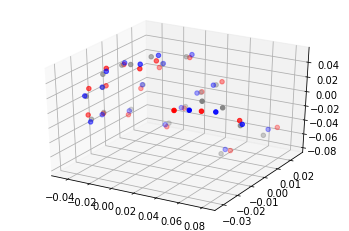

In [10]:
#visualise results
signal1_output = np.zeros((21,3))
for i in range(0,21): #for number of markers
    signal1_output[i, :] = np.array(signal1.iloc[20, i*3+1:i*3+4])
signal2_output = np.zeros((21,3))
for i in range(0,21): #for number of markers
    signal2_output[i, :] = np.array(signal2.iloc[20, i*3+1:i*3+4])    
signal3_output = np.zeros((21,3))
for i in range(0,21): #for number of markers
    signal3_output[i, :] = np.array(signal3.iloc[20, i*3+1:i*3+4])
plot(signal1_output,signal2_output,signal3_output)

# Fuse sensors using the Kalman Filter

In [11]:
def init_kalman(x, y):
    x[0,0] = y
    x[1,0] = 0
    p = [[100,0],[0,300]]
    return x, p

def prediction(x, p, q, f):
    x = np.matmul(f,x)
    p = np.matmul(np.matmul(f,p),np.transpose(f))+q
    return x, p

def update(x, p, y, r, h):
    Inn = y - np.matmul(h,x)
    S = np.matmul(np.matmul(h,p),np.reshape(h,(2,1)))+r
    K = np.matmul(p,np.reshape(h,(2,1)))/S
    
    x = x + K*Inn
    p = p - np.matmul(np.multiply(K,h),p)
    return x, p

def generate_signal(signal):
    var = calculate_var(signal)
    data = {'signal': np.array(signal),
        'var': np.reshape(var,len(var))}
    
    s = pd.DataFrame(data, columns = ['signal', 'var'])
    return s

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def calculate_var(sig):
    rw = rolling_window(np.array(sig),30)

    s_var = np.zeros((len(rw),1))

    for i in range(0,len(rw)):
        s_var[i,0] = np.var(rw[i,:])

    s_var = signal.resample(s_var,len(sig),axis=0)
    s_var = s_var*np.ones((len(sig),1))
    return s_var

def fuse_signals(sig1,sig2,sig3):
    
    s1 = generate_signal(sig1)
    s2 = generate_signal(sig2)
    s3 = generate_signal(sig3)
    
    dt = 0.01
    n = len(s1)
    x = np.zeros((2,1)) #state matrix
    p = np.zeros((2,2)) #covariance matrix-
    x_arr = np.zeros((n,2)) #kalman filter output through the whole time
    q = [[0.04,0],[0,1]] #system noise
    f = [[1,dt],[0,1]] #transition matrix
    h = np.array([1,0]) #observation matrix
    
    for i, row in s1.iterrows():
        if i == 0:
            x, p = init_kalman(x, s1.iloc[i, 0]) #initialize the state using the 1st sensor
        else:
            x, p = prediction(x,p,q,f)
            x, p = update(x,p,s1.iloc[i,0],s1.iloc[i,1],h)
            x, p = update(x,p,s2.iloc[i,0],s2.iloc[i,1],h)
            x, p = update(x,p,s3.iloc[i,0],s3.iloc[i,1],h)
    
        x_arr[i,:] = np.rot90(x)
    
    return x_arr

In [12]:
fused_data = pd.DataFrame(columns = column_names)
for i in range(0,signal1.shape[1]):
    x_arr = fuse_signals(signal1.iloc[:,i],signal2.iloc[:,i],signal3.iloc[:,i])
    fused_data.iloc[:,i] = x_arr[:,0]

In [13]:
fused_data.head()

,time,RHI1_X,RHI1_Y,RHI1_Z,RHI2_X,RHI2_Y,RHI2_Z,RHI3_X,RHI3_Y,RHI3_Z,...,RIF3_Z,RTF3_X,RTF3_Y,RTF3_Z,RRF3_X,RRF3_Y,RRF3_Z,RPF3_X,RPF3_Y,RPF3_Z
0,-2.858714e-14,0.070253,0.028217,-0.052875,0.027162,0.019864,0.005913,0.011115,0.018885,-0.009702,...,0.043233,-0.033069,-0.014385,0.042292,-0.044420,-0.018282,0.017749,-0.045329,-0.018674,-0.016001
1,-1.494608e+01,0.069238,0.025910,-0.053148,0.025353,0.018764,0.003985,0.010869,0.018566,-0.012478,...,0.048498,-0.033332,-0.014717,0.042042,-0.044219,-0.016370,0.016106,-0.042336,-0.019562,-0.019673
2,-8.710864e+00,0.069037,0.025198,-0.053388,0.025182,0.018398,0.004045,0.010785,0.018544,-0.011510,...,0.048274,-0.033364,-0.014625,0.042029,-0.044066,-0.020162,0.016454,-0.041743,-0.019571,-0.019274
3,-7.746461e-01,0.068919,0.025109,-0.053645,0.024858,0.018468,0.003273,0.010727,0.018805,-0.012736,...,0.053682,-0.034656,-0.014502,0.041742,-0.043869,-0.017792,0.016640,-0.041373,-0.019477,-0.019478
4,1.792669e+00,0.068698,0.024425,-0.053533,0.024739,0.018137,0.003742,0.010626,0.018536,-0.011559,...,0.048700,-0.033430,-0.014463,0.041830,-0.043719,-0.019863,0.016601,-0.040850,-0.019479,-0.018990


In [373]:
#fused_signal.to_csv('C:/Users/andre/Desktop/Mirror Therapy/data/fused_signal.csv')
fused_data = signal_3

In [374]:
fused_data.drop(['time'], axis = 1, inplace=True)
fused_data = fused_data*1000
fused_data.head()

,RHI1_X,RHI1_Y,RHI1_Z,RHI2_X,RHI2_Y,RHI2_Z,RHI3_X,RHI3_Y,RHI3_Z,RHI4_X,...,RIF3_Z,RTF3_X,RTF3_Y,RTF3_Z,RRF3_X,RRF3_Y,RRF3_Z,RPF3_X,RPF3_Y,RPF3_Z
0,-67.610704,284.574011,-148.393216,-15.076614,284.002485,-105.175002,-30.049562,286.086765,-91.430493,-48.696957,...,-66.155918,14.729369,254.526587,-45.591432,-12.028795,249.220316,-42.696050,-45.575478,249.062341,-60.542076
1,-67.623595,284.836299,-148.451881,-15.057427,284.409965,-105.271784,-30.025138,286.479062,-91.518819,-48.662316,...,-66.245289,14.891502,255.233524,-45.597881,-11.838670,249.857732,-42.639549,-45.245650,249.579464,-60.129457
2,-67.647173,285.107252,-148.512064,-15.053371,284.822559,-105.364957,-30.017047,286.874028,-91.604609,-48.644799,...,-66.326443,15.030613,255.919477,-45.603298,-11.670800,250.477096,-42.587543,-44.947466,250.083056,-59.752640
3,-67.681439,285.386869,-148.573764,-15.064446,285.240268,-105.454520,-30.025288,287.271665,-91.687863,-48.644408,...,-66.399380,15.146700,256.584446,-45.607681,-11.525184,251.078405,-42.540031,-44.680925,250.573117,-59.411623
4,-67.726393,285.675152,-148.636981,-15.090651,285.663092,-105.540474,-30.049863,287.671972,-91.768581,-48.661142,...,-66.464100,15.239763,257.228431,-45.611031,-11.401822,251.661662,-42.497014,-44.446029,251.049648,-59.106408


In [375]:
# Load an empty c3d structure
c3d = c3d()

In [376]:
# Fill it with data
c3d['parameters']['POINT']['RATE']['value'] = [100]
c3d['parameters']['POINT']['LABELS']['value'] = ('RH1', 'RH2', 'RH3', 'RH4', 'RH5', 'RH6',
                                                'RTH1', 'RIF1', 'RTF1', 'RRF1', 'RPF1',
                                                'RTH2', 'RIF2', 'RTF2', 'RRF2', 'RPF2',
                                                'RTH3', 'RIF3', 'RTF3', 'RRF3', 'RPF3')
c3d['data']['points'] = np.zeros((4, 21, len(fused_data)))
c3d['data']['points'][3, :, :]  = 1

In [377]:
for a in range(0,len(fused_data)): #for number of frames
    frame_data = np.zeros((3,21))
    for i in range(0,21): #for number of markers
        frame_data[:,i] = np.reshape(np.array(fused_data.iloc[a, i*3:i*3+3]),(3))
    c3d['data']['points'][0:3, :, a] = frame_data

In [378]:
c3d['parameters']['ANALOG']['RATE']['value'] = np.array([1000.])
c3d['parameters']['ANALOG']['LABELS']['value'] = []
c3d['data']['analogs'] = np.empty((1,0,len(fused_data)*10))

In [379]:
test = [i.replace("NewSubject:", "") for i in c3d['parameters']['POINT']['LABELS']['value']]
c3d['parameters']['POINT']['LABELS']['value'] = test

In [380]:
# Write the data
c3d.write("Data/Fused_Leap_data.c3d")